In [5]:
import pandas as pd
import pickle
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import TensorBoard, EarlyStopping
from keras.optimizers import RMSprop, Adagrad, Adam
#from keras.metrics import precision as prec_metric
import keras.backend as K
import numpy
# fix random seed for reproducibility
numpy.random.seed(7)

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold,StratifiedShuffleSplit
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score,roc_auc_score, roc_curve, average_precision_score,precision_recall_curve
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [6]:
# Load the training set
df = pd.read_csv('training_data/utah_training_set.csv').drop(columns=['fid','index','join_key'],errors='ignore')
df = df.dropna(how='any',axis=0)
df.head()

,timestamp,segment_id,station_id,hour,weekday,month,pre_dir,street_type,suf_dir,one_way,...,visibility,temperature,precip_depth,snow_depth,snowing,raining,foggy,icy,hailing,thunderstorm
0,2010-01-01 09:00:00+00:00,21821,72470093141,2,4,1,S,ST,,0,...,16093.0,-7.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010-01-01 18:00:00+00:00,32221,72470093141,11,4,1,S,,,0,...,16093.0,-5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-01-02 09:00:00+00:00,42886,72470093141,2,5,1,E,,,0,...,16093.0,-13.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2010-01-03 01:00:00+00:00,28854,72470093141,18,5,1,W,,,0,...,16093.0,-11.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2010-01-03 15:00:00+00:00,11320,72470093141,8,6,1,E,,,0,...,16093.0,-8.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
ohe_fields=['one_way','hour','weekday','month']
df_ohe = pd.get_dummies(df,columns=ohe_fields)

# Continuous Features
These are currently:
* Historical Accident Count
* Speed Limit (if available)
* Sinuosity (Road curavture metric)
* AADT (Annual Average Daily Traffic)
* Precipitation Depth
* Snow Depth
* Temperature
* Visibility
* Wind SPeed
* Road Orientation

In [8]:
float_feature_names = [
    'accident_counts',
    'speed_limit',
    'aadt',
    'surface_width',
    'sinuosity',
    'euclidean_length',
    'segment_length',
    'road_orient_approx',
    'precip_depth',
    'snow_depth',
    'temperature',
    'visibility',
    'wind_speed'
]
float_features = df_ohe.xs(float_feature_names,axis=1).values

scaler = StandardScaler()
'''
# Not using sklearn's scaler because I have a bunch of missing data and was feeling lazy. :)
mean_float = np.nanmean(float_features,axis=0)
std_float = np.nanstd(float_features,axis=0)

float_scaled = (float_features - mean_float) / std_float
'''
float_scaled = scaler.fit_transform(float_features)

for i,fname in enumerate(float_feature_names):
    df_ohe[fname] = float_scaled[:,i]

with open('scalers.pkl','wb') as fp:
    pickle.dump(scaler,fp)


In [10]:
y = df['target'].values
drop_columns = ['index',
                'join_key',
                'segment_id',
                'station_id',
                'timestamp',
                'target',
                'fid',
                'COFIPS',
                'street_type',
                'pre_dir',
                'surface_type',
                'suf_dir']
df_ohe = df_ohe.drop(columns=drop_columns,errors='ignore')

In [11]:
X = df_ohe.values
y = df['target'].values

In [12]:
feature_names = df_ohe.columns.tolist()
len(feature_names)

68

In [13]:
print(feature_names)

['speed_limit', 'surface_width', 'aadt', 'sinuosity', 'euclidean_length', 'segment_length', 'near_major_road', 'road_orient_approx', 'at_intersection', 'near_billboard', 'accident_counts', 'wind_speed', 'visibility', 'temperature', 'precip_depth', 'snow_depth', 'snowing', 'raining', 'foggy', 'icy', 'hailing', 'thunderstorm', 'one_way_0', 'one_way_1', 'one_way_2', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']


In [14]:
wrangler = {
    'scaler': scaler,
    'float_feature_names': float_feature_names,
    'drop_columns': drop_columns,
    'ohe_fields': ohe_fields,
    'feature_names': feature_names
}
with open('wrangler_nn.pkl','wb') as fp:
    pickle.dump(wrangler,fp)

In [75]:
# create model
model = Sequential()
model.add(Dense(50, input_dim=X.shape[1], activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(35, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(15, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [76]:
optimizer = Adam()

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

model.compile(loss='binary_crossentropy', optimizer=optimizer)

from time import time

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

model.fit(X_train, y_train,
          validation_data=(X_test,y_test), 
          epochs=50, 
          verbose=1, 
          batch_size=10000, 
          callbacks=[tensorboard,early_stopping])

Train on 1774046 samples, validate on 197117 samples
Epoch 1/50
1774046/1774046 [==============================] - 6s 3us/step - loss: 0.5542 - val_loss: 0.4977
Epoch 2/50
1774046/1774046 [==============================] - 5s 3us/step - loss: 0.5102 - val_loss: 0.4900
Epoch 3/50
1774046/1774046 [==============================] - 5s 3us/step - loss: 0.5022 - val_loss: 0.4874
Epoch 4/50
1774046/1774046 [==============================] - 5s 3us/step - loss: 0.4983 - val_loss: 0.4861
Epoch 5/50
1774046/1774046 [==============================] - 5s 3us/step - loss: 0.4956 - val_loss: 0.4848
Epoch 6/50
1774046/1774046 [==============================] - 6s 3us/step - loss: 0.4932 - val_loss: 0.4841
Epoch 7/50
1774046/1774046 [==============================] - 6s 3us/step - loss: 0.4914 - val_loss: 0.4833
Epoch 8/50
1774046/1774046 [==============================] - 6s 3us/step - loss: 0.4897 - val_loss: 0.4825
Epoch 9/50
1774046/1774046 [==============================] - 6s 3us/step - loss: 0

In [57]:
model.save('logloss.h5')

In [78]:
y_pred = model.predict(X_test)

In [79]:
ypt = y_pred>0.2
print ('Test Accuracy:',accuracy_score(y_test,ypt))
print ('Test F1:',f1_score(y_test,ypt))
print ('Test Precision:',precision_score(y_test,ypt))
print ('Test AP:',average_precision_score(y_test,ypt))
print ('Test Recall:',recall_score(y_test,ypt))
print ('Test AUC:',roc_auc_score(y_test,y_pred))

Test Accuracy: 0.575211676314
Test F1: 0.434996187559
Test Precision: 0.299755419367
Test AP: 0.28037462285
Test Recall: 0.792588767581
Test AUC: 0.708281717513


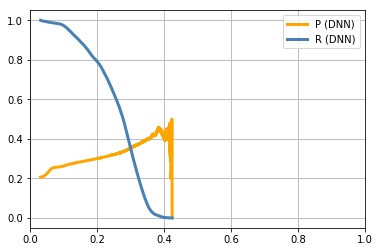

In [80]:
precision,recall,thresholds = precision_recall_curve(y_test,y_pred)

plt.plot(thresholds,precision[:-1],'r-',label='P (DNN)',color='orange',lw=3)
plt.plot(thresholds,recall[:-1],'r-',label='R (DNN)',color='steelblue',lw=3)
plt.gca().set_xbound(lower=0,upper=1)
plt.grid()
plt.legend()

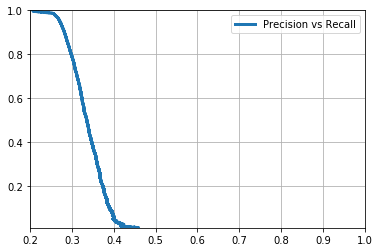

In [81]:
plt.figure(figsize=(15,15))

precision,recall,thresholds = precision_recall_curve(y_test,y_pred)

fig,ax = plt.subplots()
plt.plot(precision,recall,label='Precision vs Recall',lw=3)

ax.set_xbound(lower=0.2,upper=1.0)
ax.set_ybound(lower=0.01,upper=1.0)
plt.grid()
plt.legend()

(array([  3733.,   9207.,  11190.,  11213.,   4507.,   1299.,   1076.,
          1613.,   3527.,   4191.,   3793.,   3604.,   3362.,   3181.,
          3097.,   3087.,   3121.,   3479.,   3767.,   3394.,   2807.,
          3123.,   3755.,   4180.,   4475.,   4795.,   4845.,   4746.,
          4745.,   5279.,   5852.,   6678.,   7288.,   7131.,   6785.,
          6260.,   5646.,   5296.,   4868.,   4069.,   3374.,   2203.,
          1334.,    732.,    502.,    429.,    241.,    146.,     67.,
            25.]),
 array([ 0.03145028,  0.03930844,  0.04716661,  0.05502477,  0.06288294,
         0.0707411 ,  0.07859926,  0.08645743,  0.09431559,  0.10217376,
         0.11003192,  0.11789008,  0.12574825,  0.13360641,  0.14146458,
         0.14932274,  0.15718091,  0.16503907,  0.17289723,  0.1807554 ,
         0.18861356,  0.19647173,  0.20432989,  0.21218805,  0.22004622,
         0.22790438,  0.23576255,  0.24362071,  0.25147888,  0.25933704,
         0.2671952 ,  0.27505337,  0.28291153,

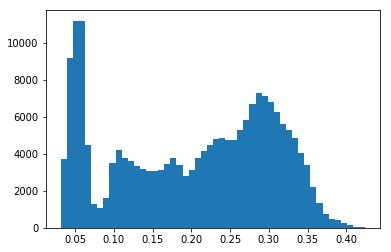

In [82]:
plt.figure()
plt.hist(y_pred,50)